In [26]:
import numpy as np

In [49]:
takeClosest = lambda num,collection:min(collection,key=lambda x:abs(x-num))
takeClosest(5,[6,4,1,88,44,3])

6

In [45]:
np.sort(a)

array([ 2,  3,  5, 19, 21])

In [48]:
a = np.array([2,3,5,21,19,21,21,21,21,19])#np.random.randint(50, size=50)
num = 20
diff, idx = get_close(a ,num)
a, a[np.where(np.abs(a- num)==np.min(np.abs(a - num)))[0][0]], num

(array([ 2,  3,  5, 21, 19, 21, 21, 21, 21, 19]), 21, 20)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import re
import matplotlib as mpl
from itertools import product
import seaborn as sns
import glob
import pickle
import os
from pycsca.csv_reader import CSVReader
from pycsca.plot_utils import pgf_with_latex, fig_param, custom_dict, colors
from pycsca.utils import progress_bar
import math
sns.set(color_codes=True)
plt.style.use('default')

In [2]:
def plot_importance(model1, model2, class_label, feature_names, folder, extension, figsize=(7, 4), number=15):
    fig_param['format'] = extension
    def norm(x):
        return (x - x.min())/(x.max()-x.min())
    def get_importances(model):
        feature_importances = model.feature_importances_
        trees = np.array(model.estimators_)
        trees = trees.flatten()
        deviation = []
        for tree in trees:
            deviation.append(tree.feature_importances_)
        std = np.std(deviation, axis=0) / len(trees)
        indices = np.argsort(feature_importances)[::-1]
        importances = norm(feature_importances)[indices][0:number]
        names = feature_names[indices[0:number]]
        std = std[indices][0:number]
        print("########################### {} ################################".format(class_label))
        if model==model1:
            for imp, s, name in zip(importances, std, names):
                print('{}:{}±{}'.format(name, imp.round(6), s.round(6)))
        return importances, std, names
    importances, std, names = get_importances(model1)
    importances2, std2, names2 = get_importances(model2)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize, frameon=True, edgecolor='k', facecolor='white')
    if '(' in class_label:
        l = class_label.index('(')
        class_label = ' '.join(class_label[0:l].split(" ")) + '\n' + ' '.join(class_label[l:].split(" ")) + '\n'
    else:
        l = int(len(class_label.split(" ")) / 2) + 1
        class_label = ' '.join(class_label.split(" ")[0:l]) + '\n' + ' '.join(class_label.split(" ")[l:]) + '\n'
    ax1.barh(range(number), importances, color="r", xerr=std, align="center")
    ax1.set_yticklabels(names)
    ax1.set_yticks(range(number))
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    ax2.barh(range(number), importances2, color="r", xerr=std2, align="center")
    ax2.set_yticks(range(number))
    ax2.set_yticklabels(names2)
    ax2.set_title('Missing-CCS-FIN', y=1.02)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    #fig.suptitle(class_label, y=0.90, fontsize=11)
    class_label = '_'.join(class_label.lower().split(' '))
    class_label = class_label.replace('\n', '')
    fname = os.path.join(folder, "importance_{}.{}".format(class_label, extension))
    fig_param['fname'] = fname
    plt.savefig(**fig_param)
    plt.show()

In [3]:
from sklearn.dummy import DummyClassifier
from matplotlib.patches import Patch
def plot_for(axs, estimators, X, y, vulnerable):
    if not vulnerable:
        cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
    else:
        cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0)
    n_instances = y.shape[0]
    estimators_names = {}
    for name in custom_dict.keys():
        for estimator in estimators:
            if name==type(estimator).__name__:
                estimators_names[name] = estimator
                #estimators_names.append(type(estimator).__name__)
    print(estimators_names)
    
    i =1
    for ax, (label, estimator) in zip(axs, estimators_names.items()):
        progress_bar(i, len(estimators_names), label)
        i+=1
        if not vulnerable:
        #train_sizes = np.linspace(0.01, 1.0, num=20)
            train_sizes = np.arange(400, n_instances, 300) / n_instances
        else:
            train_sizes = np.arange(10, 400, 20) / n_instances
        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, 
                                                                              n_jobs=os.cpu_count(),
                                                                              train_sizes=train_sizes,
                                                                              return_times=True)


        train_scores = 1 - train_scores
        test_scores = 1 - test_scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)

        # Plot learning curve
        label = label.split('Classifier')[0]

        label = '\n'.join(re.findall('[A-Z][^A-Z]*', label))
        if 'S\nG\nD' in label:
            label = "Stochastic\nGradient Descent"
        if 'Linear' in label:
            label = "Support\nVector\nMachine"
        if 'Ridge' in label:
            label = "Ridge\nClassifier"
        if 'Hist' in label:
            label = "Histogram\nGradient\nBoosting"
        if 'Dummy' in label:
            label = "Random\nGuesser"
        if vulnerable:
            ax.set_title(label, y=0.85, fontsize=10)
        diff = train_sizes[1] - train_sizes[0]
        train_sizes = np.array(train_sizes)
        tt = np.copy(train_sizes)

        ax.fill_between(tt, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color='r')
        ax.fill_between(tt, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color='k')
        if vulnerable:
            train_sizes = [int(math.ceil(i / 20)) * 20 for i in train_sizes]
        else:
            train_sizes = [int(math.ceil(i / 100)) * 100 for i in train_sizes]

        line_in = ax.plot(tt, train_scores_mean, 'o-', label='In-Sample Error $E_{in}$', markersize=1, color='r')
        line_out = ax.plot(tt, test_scores_mean, 'o-', label="Out-of-Sample Error $E_{out}$", markersize=1, color='k')
        n = 2
        if vulnerable:
            n=3
        ax.set_xticks(tt[::n])
        ax.set_xticklabels(train_sizes[::n], rotation=90, ha='center', fontsize=10)

        ax.set_xlim(tt[0]-diff, tt[-1]+diff)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylim(-0.05, 0.75)
        yticks = np.linspace(0.0, 0.7, num=8).round(1)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks, fontsize=10)
def learning_curve_for_label(estimators, X, y, vulnerable, estimators1, X1, y1, vulnerable1,
                             fname, params, extension):
    ncols = len(estimators)
    nrows = int((len(estimators) + len(estimators1))/ ncols)
    figsize = (7.0, nrows * 1.8)

    rcParams['font.family'] = 'serif'
    fontsize = 12
    rcParams['font.size'] = fontsize
    fig_param['format'] = extension
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex='row', sharey=True, figsize=figsize,
                            frameon=True, edgecolor='k', facecolor='white')
    axs = np.array(axs).flatten()
    plt.subplots_adjust(hspace=.8, wspace=0.3)


    #(axs[0], axs[2]), (axs[1], axs[3])
    plot_for(axs[0:ncols], estimators, X, y, vulnerable)
    plot_for(axs[ncols:], estimators1, X1, y1, vulnerable1)
    #plot_for((axs[0], axs[2]), estimators, X, y, vulnerable)
    #plot_for((axs[1], axs[3]), estimators1, X1, y1, vulnerable1)
    #axs[7].set_xlabel('# Training Examples', fontsize=15)
    #axs[5].set_ylabel('Accuracy', y=1.01, fontsize=15)
    axs[ncols+int(ncols/2)].set_xlabel('Number of Training Instances', x = 0.5)
    axs[ncols].set_ylabel('Error-Rate', y = 1.2)
    plt.figtext(0.50,1.1, "Damn Vulnerable\nOpenSSL", ha="center", va="top", color="k", fontsize=fontsize, weight='bold')
    plt.figtext(0.50,0.47, "OpenSSL 1.1.1i", ha="center", va="top", color="k", fontsize=fontsize, weight='bold')
    plt.legend(**params)
    fig_param['fname'] = fname
    plt.savefig(**fig_param)
    plt.show()

In [4]:
def plot_learning_curves(models_folder, csv_reader, vulnerable_classes, lrcurve_folder, imp_folder, 
                         params, extension='png'):
    def get_estimators_data(models_folder, csv_reader, label_number, missing_ccs_fin):
        X, y = csv_reader.get_data_class(class_label=label_number, missing_ccs_fin=missing_ccs_fin)
        label = csv_reader.inverse_label_mapping[label_number]
        if missing_ccs_fin:
            label = label + ' Missing-CCS-FIN'

        name = '-' + '_'.join(label.lower().split(' ')) + '.pickle'
        estimators = []
        files = glob.glob(os.path.join(models_folder, '*.pickle'))
        #files.sort()
        for pic in files:
            if name in pic and ('decision' in pic or 'perceptron' in pic):# or 'perceptron' in pic):
                print(name, pic)
                with open(pic, 'rb') as f:
                    model = pickle.load(f)
                    estimators.append(model)
        return label, estimators, X, y
    for missing_ccs_fin, (label, label_number) in product(csv_reader.ccs_fin_array, list(csv_reader.label_mapping.items())):
        if not ('Wrong First' in label and not missing_ccs_fin):
            continue
        label, estimators, X, y = get_estimators_data(models_folder, csv_reader, label_number=label_number,
                                                      missing_ccs_fin=missing_ccs_fin)
        vulnerable = label in vulnerable_classes

        result_folder = os.path.join(os.getcwd(), 'results')

        if not missing_ccs_fin:
            name = 'RandomForestClassifier'.lower() + '-' + '_'.join(label.lower().split(' ')) + '.pickle'
            f = open(os.path.join(models_folder, name), 'rb')
            model1 = pickle.load(f)
            model1.n_estimators = 500
            model1.fit(X, y)
            label1 = label + ' Missing-CCS-FIN'
            name = 'RandomForestClassifier'.lower() + '-' + '_'.join(label1.lower().split(' ')) + '.pickle'
            f = open(os.path.join(models_folder, name), 'rb')
            model2 = pickle.load(f)
            model2.n_estimators = 500
            X1, y1 = csv_reader.get_data_class(class_label=label_number, missing_ccs_fin=True)
            model2.fit(X1, y1)

            #plot_importance(model1, model2, label, csv_reader.feature_names, result_folder, 
            #                extension=extension, figsize= (3.33, 4.5), number=10)
        if len(estimators) != 0:
            label = label.replace(" ", "_")
            if vulnerable:
                label = label + '_vulnerable'
            else:
                label = label + '_non-vulnerable'
            fname = os.path.join(result_folder, "learning_curves_{}.{}".format(label, extension))
            learning_curve_for_label(estimators, X, y, vulnerable, fname, params, extension)
            print("###########################{}-{}###########################".format(vulnerable, label))

In [5]:
from matplotlib import rcParams
def plot_lr(folder, params, extension):
    csv_reader = CSVReader(folder=folder, seed=42)
    plots_folder = os.path.join(folder, 'Plots')
    models_folder = os.path.join(folder, 'Models')
    with open(os.path.join(folder, 'Vulnerable Classes.pickle'), 'rb') as f:
        vulnerable_classes = pickle.load(f)
    lrcurve_folder = os.path.join(plots_folder, 'Learning Curves')
    if not os.path.exists(lrcurve_folder):
        os.mkdir(lrcurve_folder)
    imp_folder = os.path.join(plots_folder, 'Feature Importance')
    if not os.path.exists(imp_folder):
        os.mkdir(imp_folder)
    fig_param['format'] = extension
    
    def get_estimators_data(models_folder, csv_reader, label_number, missing_ccs_fin):
        X, y = csv_reader.get_data_class(class_label=label_number, missing_ccs_fin=missing_ccs_fin)
        label = csv_reader.inverse_label_mapping[label_number]
        if missing_ccs_fin:
            label = label + ' Missing-CCS-FIN'

        name = '-' + '_'.join(label.lower().split(' ')) + '.pickle'
        estimators = []
        files = glob.glob(os.path.join(models_folder, '*.pickle'))
        files.sort()
        for pic in files:
            if name in pic and ('randomforest' in pic or 'perceptron' in pic or 'svc' in pic
                                or 'decision' in pic or 'hist' in pic):# or 'perceptron' in pic):
                print(name, pic)
                with open(pic, 'rb') as f:
                    model = pickle.load(f)
                    estimators.append(model)
        return label, estimators, X, y
    label, estimators, X, y = get_estimators_data(models_folder, csv_reader, label_number=9,
                                                      missing_ccs_fin=False)
    vulnerable = label in vulnerable_classes
    return label, estimators, X, y, vulnerable
    #plot_learning_curves(models_folder, csv_reader, vulnerable_classes, lrcurve_folder, 
    #                     imp_folder, params, extension=extension)

-wrong_first_byte_(0x00_set_to_0x17).pickle /home/pritha/git/datasets/2021-01-14-damnvulnerableopensslserverfast/Models/decisiontreeclassifier-wrong_first_byte_(0x00_set_to_0x17).pickle
-wrong_first_byte_(0x00_set_to_0x17).pickle /home/pritha/git/datasets/2021-01-14-damnvulnerableopensslserverfast/Models/histgradientboostingclassifier-wrong_first_byte_(0x00_set_to_0x17).pickle
-wrong_first_byte_(0x00_set_to_0x17).pickle /home/pritha/git/datasets/2021-01-14-damnvulnerableopensslserverfast/Models/linearsvc-wrong_first_byte_(0x00_set_to_0x17).pickle
-wrong_first_byte_(0x00_set_to_0x17).pickle /home/pritha/git/datasets/2021-01-14-damnvulnerableopensslserverfast/Models/perceptron-wrong_first_byte_(0x00_set_to_0x17).pickle
-wrong_first_byte_(0x00_set_to_0x17).pickle /home/pritha/git/datasets/2021-01-14-damnvulnerableopensslserverfast/Models/randomforestclassifier-wrong_first_byte_(0x00_set_to_0x17).pickle
-wrong_first_byte_(0x00_set_to_0x17).pickle /home/pritha/git/datasets/2021-01-14-openss

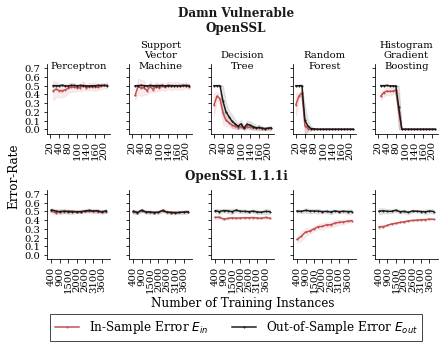

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
%matplotlib inline

extension = 'pgf'
params = dict(loc='lower center', bbox_to_anchor=(-2.2, -1.25), ncol=2, fancybox=False, 
              frameon=True, shadow=False, facecolor='white', edgecolor='k')
folder = os.path.join(os.getcwd(), "2021-01-14-damnvulnerableopensslserverfast")

label, estimators, X, y, vulnerable = plot_lr(folder, params, extension)

folder = os.path.join(os.getcwd(), "2021-01-14-opensslserver111i")
label1, estimators1, X1, y1, vulnerable1 = plot_lr(folder, params, extension)
fname = os.path.join(os.getcwd(), 'results', 'learning_curves.'+extension)

learning_curve_for_label(estimators, X, y, vulnerable, estimators1, X1, y1, vulnerable1, fname, params, extension)
